In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from typing import List
from EasyMCDM.models.Pareto import Pareto
import numpy as np
import numpy.typing as npt  
import os


def get_pareto_optimal_mask(data: npt.NDArray, optimization_direction: List[str]) -> npt.NDArray:
    '''
    `data`: scores to explore   
    `optimization direction`: list of ['max' and 'min'] of the data feature length

    return mask to the data with 1 in positions of pareto optimal datapoints 
    '''
    data_dic = {i: row for i, row in enumerate(data)}

    solver = Pareto(data_dic, verbose=False)
    result = solver.solve(indexes=list(range(data.shape[1])), prefs=optimization_direction)

    mask = np.zeros(data.shape[0])
    
    for k, v in result.items():
        if len(v['Dominated-by']) > 0:
            mask[int(k)] = False
        else:
            mask[int(k)] = True

    return mask
def get_optimization_direction(metric_name: str) -> str:
    cost_criteria = ['feasibility', 'proximity', 'features']
    gain_criteria = ['discriminative', 'dcg']

    cost = any([True if x.lower() in metric_name.lower() else False for x in cost_criteria])
    if cost:
        return 'min'
    else:
        return 'max'

In [3]:
dfs: List = [] 
dataset_name = 'adult' #'german'
explained_model = 'NN'

idcs = []
directory = './2023-02-06'

_, _, stats_filenames = os.walk(f'{directory}/scores/').__next__()
for stat_filename in stats_filenames:
    if dataset_name not in stat_filename:
        continue 

    dataset_name, explained_model, index, date = stat_filename.split('_')
    index = index[1:]
    date = date[:-5]
    #print(f'dataset: {dataset_name}, model: {explained_model}, index: {index}, date: {date}')
    idcs.append(index)
    with open(f'{directory}/scores/' + stat_filename, 'r') as f:
        df = pd.read_csv(f)

    dfs.append(df)

all_scores = pd.concat(dfs)
# index_to_plot = 1
# all_scores = dfs[index_to_plot]
all_scores.head(5)

,Proximity,Feasibility,K_Feasibility(3),FeaturesChanged,DiscriminativePower(9),DCG@6,explainer
0,1.200000,1.135160,1.208505,0.181818,0.000000,0.458094,dice
1,2.000000,1.576256,1.930575,0.181818,0.555556,0.000000,dice
2,2.000000,2.201826,2.288870,0.181818,0.111111,0.386853,dice
3,2.000000,1.554767,1.589526,0.181818,0.555556,0.386853,dice
4,1.244898,0.887820,1.407850,0.181818,0.111111,0.510721,dice


In [7]:
all_x = all_scores['Proximity'].to_numpy()
all_y = all_scores['K_Feasibility(3)'].to_numpy()
all_z = all_scores['DCG@6'].to_numpy()
optimization_direction = ['min', 'min', 'max']
to_check = np.array([all_x, all_y, all_z], dtype=np.float64).T

all_pareto = get_pareto_optimal_mask(to_check, optimization_direction).astype('bool')

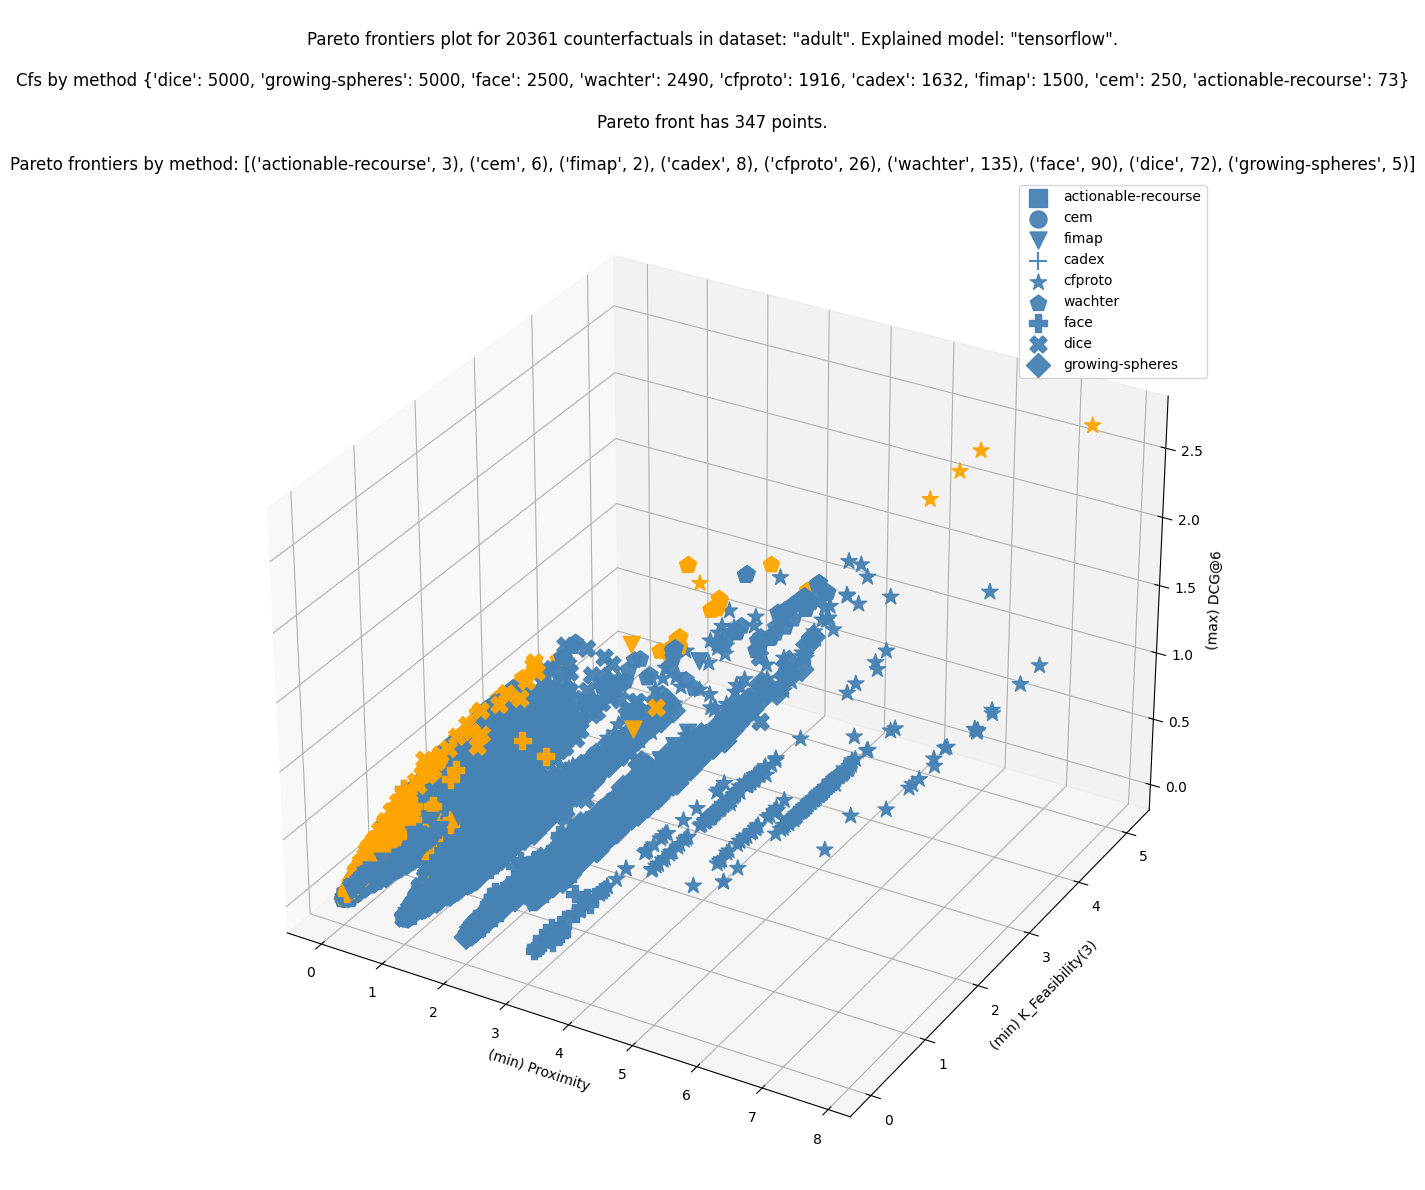

In [32]:
scores_to_plot = all_scores.copy()
metric, other_metric, other_other_metric = 'Proximity', 'K_Feasibility(3)', 'DCG@6'

counts = scores_to_plot['explainer'].value_counts()

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['s', 'o', 'v', '+', '*', 'p', 'P', 'X', 'D', '>']


fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(projection='3d')

pareto_counterfactuals_by_method_counts = {}

for plot_round in ['nonpareto', 'pareto']:
    for k, explainer in enumerate(scores_to_plot['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

        mask = scores_to_plot['explainer'] == explainer
        pareto = all_pareto[mask]

        x = scores_to_plot[mask][metric].to_numpy()
        y = scores_to_plot[mask][other_metric].to_numpy()
        z = scores_to_plot[mask][other_other_metric].to_numpy()

        pareto_counterfactuals_by_method_counts[explainer] = sum(pareto)

        if plot_round == 'nonpareto':
            ax.scatter(x[~pareto], y[~pareto], z[~pareto], color='steelblue', marker=markers[k], label=explainer, alpha=0.95, s=150)
        elif plot_round == 'pareto':
            ax.scatter(x[pareto], y[pareto], z[pareto], color='orange', marker=markers[k], alpha=0.95, s=150)
         
ax.set_xlabel(f'({optimization_direction[0]}) {metric}')
ax.set_ylabel(f'({optimization_direction[1]}) {other_metric}')
ax.set_zlabel(f'({optimization_direction[2]}) {other_other_metric}')

plt.title(f'''
Pareto frontiers plot for {scores_to_plot.shape[0]} counterfactuals in dataset: "{dataset_name}". Explained model: "{explained_model}".\n
Cfs by method {counts.to_dict()}\n
Pareto front has {sum(all_pareto)} points.\n
Pareto frontiers by method: {list(filter(lambda x: x[1] > 0, pareto_counterfactuals_by_method_counts.items()))}'''
)

# plt.savefig(f'images/{dataset_name}/{explained_model}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_{instance_to_explain_index}.png')
plt.tight_layout()
plt.legend()
plt.savefig(f'images/{dataset_name}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_all.png')
# plt.savefig(f'images/{dataset_name}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_i{index_to_plot}.png')
plt.show()

Plot single instance

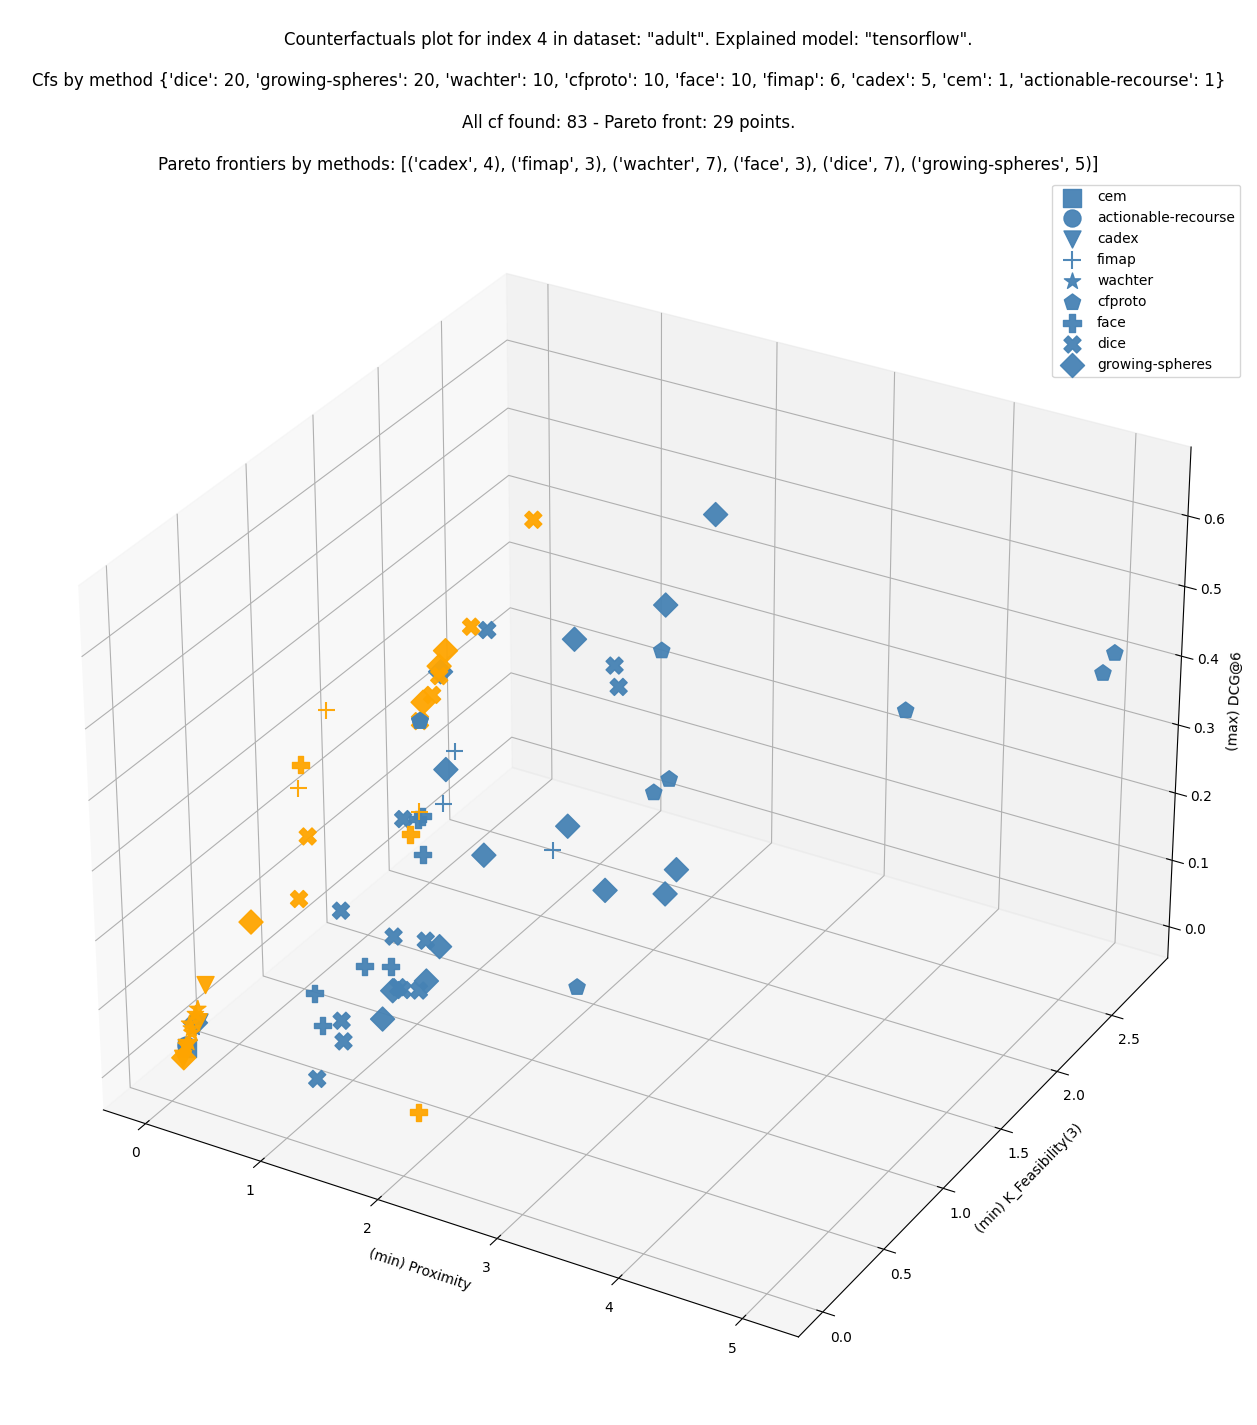

In [26]:
index_to_explain = 4
scores_to_plot_single = dfs[index_to_explain].copy()


single_x = scores_to_plot_single['Proximity'].to_numpy()
single_y = scores_to_plot_single['K_Feasibility(3)'].to_numpy()
single_z = scores_to_plot_single['DCG@6'].to_numpy()
optimization_direction = ['min', 'min', 'max']
to_check = np.array([single_x, single_y, single_z], dtype=np.float64).T

single_pareto = get_pareto_optimal_mask(to_check, optimization_direction).astype('bool')


metric, other_metric, other_other_metric = 'Proximity', 'K_Feasibility(3)', 'DCG@6'

counts = scores_to_plot_single['explainer'].value_counts()

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['s', 'o', 'v', '+', '*', 'p', 'P', 'X', 'D', '>']


fig = plt.figure(figsize=(13, 14))
ax = fig.add_subplot(projection='3d')

pareto_counterfactuals_by_method_counts = {}

for plot_round in ['nonpareto', 'pareto']:
    for k, explainer in enumerate(scores_to_plot_single['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

        mask = scores_to_plot_single['explainer'] == explainer
        pareto = single_pareto[mask]

        x = scores_to_plot_single[mask][metric].to_numpy()
        y = scores_to_plot_single[mask][other_metric].to_numpy()
        z = scores_to_plot_single[mask][other_other_metric].to_numpy()

        pareto_counterfactuals_by_method_counts[explainer] = sum(pareto)

        if plot_round == 'nonpareto':
            ax.scatter(x[~pareto], y[~pareto], z[~pareto], color='steelblue', marker=markers[k], label=explainer, alpha=0.95, s=150)
        elif plot_round == 'pareto':
            ax.scatter(x[pareto], y[pareto], z[pareto], color='orange', marker=markers[k], alpha=0.95, s=150)
         
ax.set_xlabel(f'({optimization_direction[0]}) {metric}')
ax.set_ylabel(f'({optimization_direction[1]}) {other_metric}')
ax.set_zlabel(f'({optimization_direction[2]}) {other_other_metric}')

plt.title(f'''
Counterfactuals plot for index {index_to_explain} in dataset: "{dataset_name}". Explained model: "{explained_model}".\n
Cfs by method {counts.to_dict()}\n
All cf found: {scores_to_plot_single.shape[0]} - Pareto front: {sum(single_pareto)} points.\n
Pareto frontiers by methods: {list(filter(lambda x: x[1] > 0, pareto_counterfactuals_by_method_counts.items()))}'''
)

# plt.savefig(f'images/{dataset_name}/{explained_model}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_{instance_to_explain_index}.png')
#plt.savefig(f'images/{dataset_name}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_all.png')
plt.tight_layout()
plt.legend()
plt.savefig(f'images/{dataset_name}/3d_{dataset_name}_{explained_model}_pairplot_with_frontiers_{metric}-{other_metric}-{other_other_metric}_i{index_to_explain}.png')
plt.show()